# Introduction to LangGraph

Building truely useful agents is complicated, with multiple flows, tools and decision points.

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.

Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions. As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features.

# Getting started with LangGraph

At its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:


1.   **State**: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.
2.   **Nodes**: Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State.
3.   **Edges**: Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.


By composing Nodes and Edges, you can create complex, looping workflows that evolve the State over time. The real power, though, comes from how LangGraph manages that State. To emphasize: Nodes and Edges are nothing more than Python functions - they can contain an LLM or just good ol' Python code.

> *In* short: nodes do the work. edges tell what to do next.

Reference: https://langchain-ai.github.io/langgraph/concepts/low_level/

## Installation

In [1]:
%pip install --quiet -U langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 10.5 MB/s eta 0:00:00


## State

One of the central concepts of LangGraph is **state**. Each graph execution creates a state that is passed between nodes in the graph as they execute, and each node updates this internal state with its return value after it executes.

* When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state). The state schema represents the structure and types of data that our graph will use. All nodes are expected to communicate with that schema.
* The `MessageGraph` class is a special type of graph. The State of a MessageGraph is ONLY a list of messages. This class is rarely used except for chatbots, as most applications require the State to be more complex than a list of messages.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

There are many way to specify state. We can use the `TypedDict` class from python's `typing` module that allows us to specify keys and their corresponding value types.

However this not enforced at runtime! This means you could potentially assign invalid values without raising an error!

In [2]:
from typing import Literal
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

## Nodes

In [4]:
def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

In [5]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state['name']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

## Building the graph

In [6]:
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

## Compiling the graph

To build your graph, you first define the state, you then add nodes and edges, and then you compile it. What exactly is compiling your graph and why is it needed?

Compiling is a pretty simple step. It provides a few basic checks on the structure of your graph (no orphaned nodes, etc). It is also where you can specify runtime args like checkpointers and breakpoints. You compile your graph by just calling the .compile method:

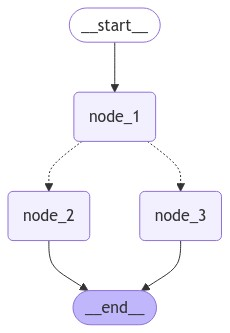

In [7]:
from IPython.display import Image, display

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"name" : "Lance"})

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## State Reducers

Reducers are key to understanding how updates from nodes are applied to the State. Each key in the State has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it.


Let's understand this with an example with two nodes running in parallel.

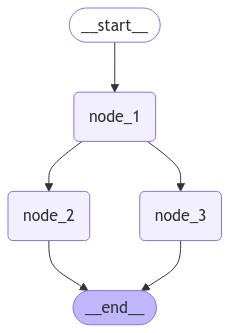

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"name" : "Lance"})

---Node 1---
---Node 2---
---Node 3---


InvalidUpdateError: At key 'mood': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

What just happened?!

In the above example, as shown by the error, two nodes are trying to simulataneously update the state.
> InvalidUpdateError: At key 'mood': Can receive only one value per step. Use an Annotated key to handle multiple values.



**Reducers**
Reducers give us a general way to address this problem. They specify how to perform updates. We can use the Annotated type to specify a reducer function.

For example, in this case let's append the value returned from each node rather than overwriting them. We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module. When operator.add is applied to lists, it performs list concatenation.

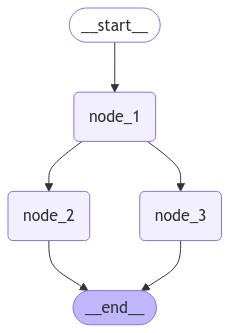

In [16]:
from operator import add
from typing import Annotated

class State(TypedDict):
    name: str
    mood: Annotated[list[str], add]

def node_1(state):
    print("---Node 1---")
    return {"name": state['name']}

def node_2(state):
    print("---Node 2---")
    return {"mood": ["happy"]}

def node_3(state):
    print("---Node 3---")
    return {"mood":[ "sad"]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({"name" : "Lance"})

---Node 1---
---Node 2------Node 3---



{'name': 'Lance', 'mood': ['happy', 'sad']}

Now the moods are being added to the state - yay!

## Human-in-the-Loop & Breakpoints

It can often be useful to set breakpoints before or after certain nodes execute. This can be used to wait for human approval before continuing. These can be set when you "compile" a graph. You can set breakpoints either before a node executes (using `interrupt_before`) or after a node executes (using interrupt_after.)

You **MUST** use a checkpoiner when using breakpoints. This is because your graph needs to be able to resume execution.

In order to resume execution, you can just invoke your graph with None as the input.

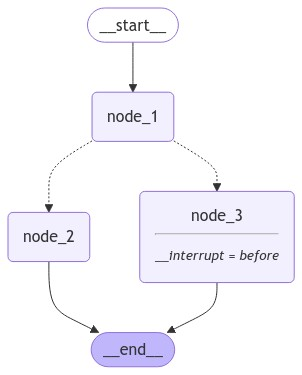

In [18]:
from operator import add
from typing import Annotated
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    name: str
    mood: Annotated[list[str], add]

def node_1(state):
    print("---Node 1---")
    return {"name": state['name']}

def node_2(state):
    print("---Node 2---")
    return {"mood": ["happy"]}

def node_3(state):
    print("---Node 3---")
    return {"mood":["sad"]}


def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state['name']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.1:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
memory = MemorySaver()
graph = builder.compile(interrupt_before=["node_3"], checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# Input
initial_input = {"name": "Lance"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption: stream_mode: "values" or "updates"
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'name': 'Lance', 'mood': []}
---Node 1---
{'name': 'Lance', 'mood': []}


In [ ]:
state = graph.get_state(thread)
state.next

('node_3',)

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'name': 'Lance', 'mood': []}
---Node 3---
{'name': 'Lance', 'mood': ['sad']}


## Difference Between State and Checkpoint

State: It Represents the current snapshot of the application at any given moment. It is dynamic and evolves as nodes in the graph execute, reflecting real-time changes and updates. State is used by nodes to perform computations and determine the next steps in the workflow.

Checkpoint: A checkpoint is a saved version of the state at a specific point in time during graph execution. It allows the system to pause and resume execution, preserving the context for future interactions. Checkpoints facilitate human-in-the-loop workflows by enabling users to inspect and modify the state before continuing execution.

Thread ID

In LangGraph, a thread_id is a unique identifier associated with a specific thread of execution within the system. Each thread represents a distinct flow of interaction or conversation, allowing the system to manage multiple dialogues or processes simultaneously. Memory in LangGraph is tied to thread_id in the following ways:

Reference: [Beginners Guide to Langgraph Memory](https://medium.com/@kbdhunga/beginners-guide-to-langgraph-memory-part-3-ad7fb15ab462#:~:text=Thread%20ID,multiple%20dialogues%20or%20processes%20simultaneously.)

## Subgraphs, Parallelization and Map-Reduce (optional!)

There are many powerful things you can do with LangGraph. Try them out!

1.   [Subgraph Example](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb#scrollTo=05b26c51)
2.   [Parallelization Example](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb#scrollTo=bfb4f56c-3334-4927-8ed8-62fd384ee43e)
3.   [Map Reduce](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb)





# Example: Simple QnA Agent



## Setup the environment

In [20]:
%pip install --quiet -U langchain_community  langchain-google-genai wikipedia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00


In [21]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [22]:
_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


In [23]:
_set_env("LANGCHAIN_API_KEY")

LANGCHAIN_API_KEY: ··········


In [38]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "ai-agent-builder-workshop"

In [25]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


## Setup the model

In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature = 0)

## Define the state and nodes

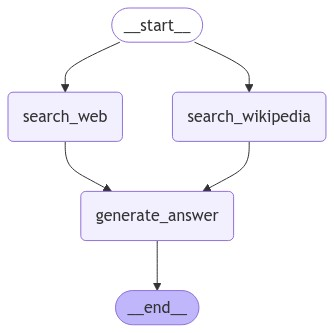

In [29]:
from operator import add
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, add]

def search_web(state):

    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
result = graph.invoke({ "question": "Who is the current president of Singapore?"})
result['answer'].content

'The current president of Singapore is **Tharman Shanmugaratnam**. \n'

Let's check the the LLM didn't already know this answer!

In [37]:
llm.invoke('Who is the current president of Singapore?')

AIMessage(content='The current president of Singapore is **Halimah Yacob**. She was elected in 2017 and is the first female president of Singapore. \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-052e6503-2d39-47c3-9ab0-891e36d891cb-0', usage_metadata={'input_tokens': 9, 'output_tokens': 31, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}})

In [36]:
result['context']

['<Document href="https://www.channelnewsasia.com/singapore/tharman-shanmugaratnam-swearingin-singapore-president-3763676"/>\nEdition Menu\nFollow our news\nMain navigation\nSingapore\nFollow our news\nAdvertisement\nAdvertisement\nSingapore\nTharman Shanmugaratnam sworn in as Singapore\'s ninth President\nSingapore\'s President Tharman Shanmugaratnam takes his oath at the Istana on Sep 14, 2023. “I will do my utmost to support initiatives that deepen the respect we accord to our fellow citizens, of all backgrounds and in every walk of life - the respect for all that is at the heart of our solidarity as Singaporeans," he added.\n Mr Tharman took his oath of office at the State Room of the Istana, in front of guests that included former presidents Halimah Yacob and Tony Tan, as well as members of the Cabinet.\n He also promised to work with the government, community groups, voluntary organisations and the entire nation to strengthen Singapore’s multiracialism, and nurture a more inclusi

# Build your own agent!

Time to get creative and build your own agent!

Remember -


1.   Define your agent state.
2.   Define the nodes
3.   Define the connections or edges between the nodes. Note, edges can be conditional.
4.   Add memory, if required.
5.   Compile your agent.
6.   Test it!



You can use this [Research AI Assistant](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) as an inspiration!

Or refer to these use-cases: https://langchain-ai.github.io/langgraph/tutorials/


# References

1.   [LangChain Academy](https://github.com/langchain-ai/langchain-academy/tree/main)
2.   [Building Agentic Workflows using LangGraph: Key Learnings](https://medium.com/@anuragmishra_27746/hands-on-build-agentic-workflow-using-langgraph-key-learnings-from-langchain-academy-part-1-9ad96d6c9210)